# **KLASIFIKASI JENIS SAMPAH**

**Federico Matthew Pratama - 233405001 - Machine Learning**

## **LIBRARY + SETUP**

### **IMPORT LIBRARY**

In [8]:
# Core
import os
import numpy as np
import matplotlib.pyplot as plt

# TensorFlow & Keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Dense, Dropout, GlobalAveragePooling2D
)
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img

# Evaluate
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### **GLOBAL PARAMETER**

In [3]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10

## **SETUP DATASET**

### **UPLOAD KAGGLE API**

In [5]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

### **DOWNLOAD DATASET FROM KAGGLE**

In [10]:
!kaggle datasets download -d techsash/waste-classification-data
!unzip waste-classification-data.zip -d dataset

Streaming output truncated to the last 5000 lines.
  inflating: dataset/dataset/DATASET/TRAIN/R/R_5499.jpg  
  inflating: dataset/dataset/DATASET/TRAIN/R/R_55.jpg  
  inflating: dataset/dataset/DATASET/TRAIN/R/R_550.jpg  
  inflating: dataset/dataset/DATASET/TRAIN/R/R_5500.jpg  
  inflating: dataset/dataset/DATASET/TRAIN/R/R_5501.jpg  
  inflating: dataset/dataset/DATASET/TRAIN/R/R_5502.jpg  
  inflating: dataset/dataset/DATASET/TRAIN/R/R_5503.jpg  
  inflating: dataset/dataset/DATASET/TRAIN/R/R_5504.jpg  
  inflating: dataset/dataset/DATASET/TRAIN/R/R_5505.jpg  
  inflating: dataset/dataset/DATASET/TRAIN/R/R_5506.jpg  
  inflating: dataset/dataset/DATASET/TRAIN/R/R_5507.jpg  
  inflating: dataset/dataset/DATASET/TRAIN/R/R_5508.jpg  
  inflating: dataset/dataset/DATASET/TRAIN/R/R_5509.jpg  
  inflating: dataset/dataset/DATASET/TRAIN/R/R_551.jpg  
  inflating: dataset/dataset/DATASET/TRAIN/R/R_5510.jpg  
  inflating: dataset/dataset/DATASET/TRAIN/R/R_5511.jpg  
  inflating: dataset/data

### **CHECK DATASET**

(np.float64(-0.5), np.float64(207.5), np.float64(241.5), np.float64(-0.5))

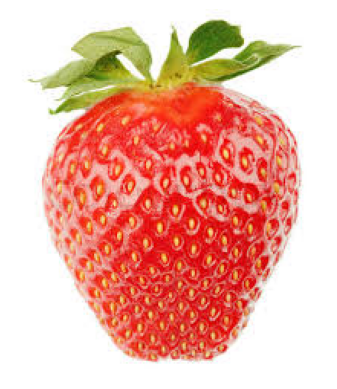

In [12]:
img_path = "dataset/DATASET/TRAIN/O/O_1.jpg"
img = load_img(img_path)

plt.imshow(img)
plt.axis('off')

## **TRAIN DATASET**

### **PREPATE DATA**

In [14]:
train_dir = "dataset/DATASET/TRAIN"
test_dir  = "dataset/DATASET/TEST"

def count_images_per_class(base_dir):
    for class_name in os.listdir(base_dir):
        class_path = os.path.join(base_dir, class_name)
        if os.path.isdir(class_path):
            num_images = len(os.listdir(class_path))
            print(f"{class_name}: {num_images} images")

print("TRAIN DATA:")
count_images_per_class(train_dir)

print("\nTEST DATA:")
count_images_per_class(test_dir)

TRAIN DATA:
O: 12565 images
R: 9999 images

TEST DATA:
O: 1401 images
R: 1112 images


### **AUGMENTASI**

In [15]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

### **LOAD TRAIN DATA**

In [16]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

Found 18052 images belonging to 2 classes.


### **LOAD VALIDATION DATA**

In [17]:
val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 4512 images belonging to 2 classes.


### **CHECK TRAINING PREPARATION STATUS**

In [20]:
print(f"Identify : {train_generator.class_indices}")
print("0 : Organic")
print("1 : Recyclable")
print()

x_batch, y_batch = next(train_generator)
print(f"X Batch Shape {x_batch.shape}")
print(f"Y Batch Shape {y_batch.shape}")

Identify : {'O': 0, 'R': 1}
0 : Organic
1 : Recyclable

X Batch Shape (32, 224, 224, 3)
Y Batch Shape (32, 2)


## **SETUP MODEL**

### **LOAD MODEL**

In [21]:
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### **BUILD MODEL**

In [22]:
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False  # freeze backbone

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

### **COMPILE MODEL**

In [23]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,210 (9.24 MB)

 Trainable params: 164,226 (641.51 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## **TRAIN DATA**

### **BUILD EARLY STOP**

In [25]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

### **TRAIN**

In [26]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[early_stop]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
565/565 ━━━━━━━━━━━━━━━━━━━━ 273s 452ms/step - accuracy: 0.8664 - loss: 0.3266 - val_accuracy: 0.9322 - val_loss: 0.1767
Epoch 2/15
565/565 ━━━━━━━━━━━━━━━━━━━━ 245s 435ms/step - accuracy: 0.9293 - loss: 0.1832 - val_accuracy: 0.9371 - val_loss: 0.1656
Epoch 3/15
565/565 ━━━━━━━━━━━━━━━━━━━━ 256s 454ms/step - accuracy: 0.9385 - loss: 0.1597 - val_accuracy: 0.9335 - val_loss: 0.1733
Epoch 4/15
565/565 ━━━━━━━━━━━━━━━━━━━━ 269s 476ms/step - accuracy: 0.9465 - loss: 0.1422 - val_accuracy: 0.9362 - val_loss: 0.1640
Epoch 5/15
565/565 ━━━━━━━━━━━━━━━━━━━━ 266s 472ms/step - accuracy: 0.9497 - loss: 0.1342 - val_accuracy: 0.9238 - val_loss: 0.1872
Epoch 6/15
565/565 ━━━━━━━━━━━━━━━━━━━━ 239s 424ms/step - accuracy: 0.9514 - loss: 0.1292 - val_accuracy: 0.9464 - val_loss: 0.1483
Epoch 7/15
565/565 ━━━━━━━━━━━━━━━━━━━━ 240s 424ms/step - accuracy: 0.9538 - loss: 0.1196 - val_accuracy: 0.9379 - val_loss: 0.1570
Epoch 8/15
565/565 ━━━━━━━━━━━━━━━━━━━━ 240s 424ms/step - accuracy: 0.9590 -

## **EVALUATE**

### **MATPLOT**

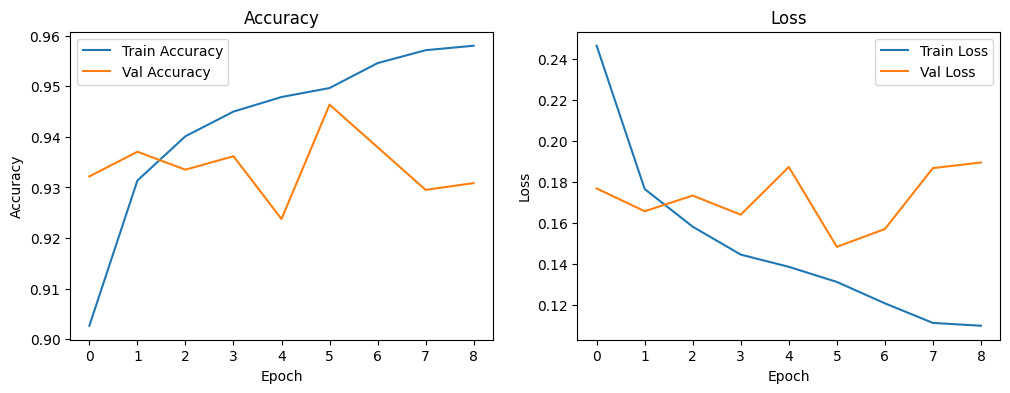

In [28]:
plt.figure(figsize=(12,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

### **OVERVIEW RESULT**

In [29]:
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

141/141 ━━━━━━━━━━━━━━━━━━━━ 48s 342ms/step - accuracy: 0.9561 - loss: 0.1326
Validation Accuracy: 0.9497
Validation Loss: 0.1414


### **SETUP TEST GENERATOR**

In [30]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 2513 images belonging to 2 classes.


#### **TEST ACCURACY**

In [31]:
test_loss, test_acc = model.evaluate(test_generator)

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

79/79 ━━━━━━━━━━━━━━━━━━━━ 13s 167ms/step - accuracy: 0.9368 - loss: 0.1730
Test Accuracy: 0.8961
Test Loss: 0.2857


### **CONFUSION MATRIX**

#### **TEXT**

In [32]:
y_pred_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)

y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred)
print(cm)

79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 101ms/step
[[1358   43]
 [ 218  894]]


### **VISUAL**

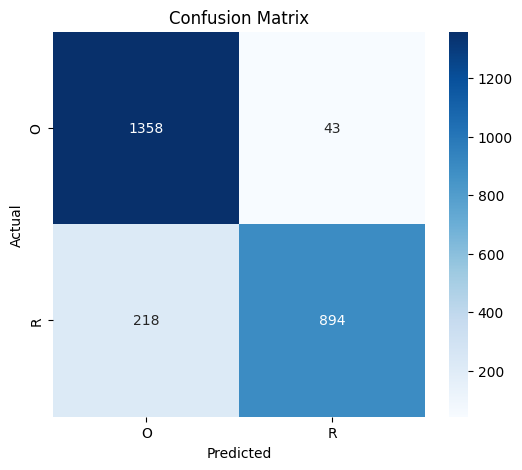

In [33]:
class_names = list(test_generator.class_indices.keys())

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

#### **CLASSIFICATION REPORT**

In [34]:
print(classification_report(
    y_true,
    y_pred,
    target_names=class_names
))

              precision    recall  f1-score   support

           O       0.86      0.97      0.91      1401
           R       0.95      0.80      0.87      1112

    accuracy                           0.90      2513
   macro avg       0.91      0.89      0.89      2513
weighted avg       0.90      0.90      0.89      2513



## **SAVE MODEL**

In [35]:
model.save("waste_classifier_mobilenet.keras")

## **TESTING**

#### **LOAD MODEL**

In [37]:
from tensorflow.keras.models import load_model

model = load_model("waste_classifier_mobilenet.keras")

### **SETUP TEST FUNCTION**

In [38]:
def predict_image(img_path):
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    class_idx = np.argmax(prediction)

    labels = {0: "Organic", 1: "Recyclable"}

    return labels[class_idx], prediction[0][class_idx]

### **TEST**

Saving bahlik.jpg to bahlik.jpg
Uploaded image: bahlik.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Prediction: Recyclable
Confidence: 0.98


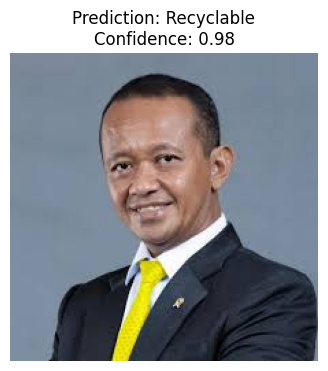

File gambar sudah dihapus.


In [51]:
from google.colab import files
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

uploaded = files.upload()

img_path = list(uploaded.keys())[0]
print("Uploaded image:", img_path)

label, confidence = predict_image(img_path)

print(f"Prediction: {label}")
print(f"Confidence: {confidence:.2f}")

img = load_img(img_path)

plt.figure(figsize=(4,4))
plt.imshow(img)
plt.title(f"Prediction: {label}\nConfidence: {confidence:.2f}")
plt.axis('off')
plt.show()

# hapus file setelah dipakai
os.remove(img_path)
print("File gambar sudah dihapus.")

##